In [6]:
from collections import Counter

import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier


In [7]:
'''Create useful functions'''

# create classification metrics function
def get_classification_metrics(y_real, y_pred):
    cm = confusion_matrix(y_real, y_pred)
    print('Confusion Matrix: \n', cm)   
    tp = cm[0,0]
    tn = cm[1,1]
    fn = cm[0,1]
    fp = cm[1,0]

    accurancy = (tp + tn) / cm.sum()
    print(f'Accuracy:{round(accurancy, 4)}.')

    sensitivity = tp / (tp + fn)
    print(f'Sensitivity:{round(sensitivity, 4)}.')

    specificity = tn / (tn + fp)
    print(f'Specificity:{round(specificity, 4)}.')

    mean_sensitivity_specificity = (sensitivity + specificity) / 2
    print(f'Mean Sensitivity & Specificity:{round(mean_sensitivity_specificity, 4)}.')

    return {'accuracy': accurancy, 'sensitivity': sensitivity, 'specificity': specificity, 'mean_sensitivity_specificity': mean_sensitivity_specificity}



In [8]:
# create artificial dataset function
def get_artificial_dataset(use_scaling):
    x_array, y_array = make_classification(
        n_classes=2, class_sep=1.2, weights=[0.98, 0.02], n_informative=3, n_redundant=1, flip_y=0, n_features=10,
        n_clusters_per_class=3, n_samples=30000, random_state=10
    )

    if use_scaling:
        scaled_x_array = StandardScaler().fit_transform(x_array)
        return scaled_x_array, y_array
    else: 
        return x_array, y_array

%age of minority class obs in testing set: 0.0202.
%age of minority class obs in testing set: 0.0194.
Counter({0: 20575, 1: 425})
Counter({0: 8825, 1: 175})


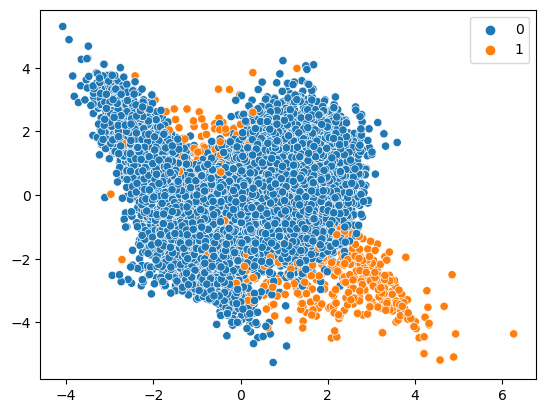

In [14]:
'''create artificial dataset'''

# get dataset
x_array, y_array = get_artificial_dataset(use_scaling=True)

# train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_array, y_array, test_size=0.3, random_state=500)
print(f'%age of minority class obs in testing set: {round(Counter(y_train)[1]/(Counter(y_train)[0]+ Counter(y_train)[1]), 4)}.')
print(f'%age of minority class obs in testing set: {round(Counter(y_test)[1]/(Counter(y_test)[0]+ Counter(y_test)[1]), 4)}.')

# visualize data after simple 2d dimensionality reduction
x_pca = PCA(n_components=2).fit_transform(x_array)
sns.scatterplot(x=x_pca[:,0], y=x_pca[:,1], hue=y_array)
print(Counter(y_train))
print(Counter(y_test))

In [15]:
'algorithm_level_treatments'

# k-nearest neighbors
knn = KNeighborsClassifier().fit(x_train, y_train)
knn_predicted = knn.predict(x_test)
knn_metrics = get_classification_metrics(y_test, knn_predicted)

Confusion Matrix: 
 [[8821    4]
 [ 103   72]]
Accuracy:0.9881.
Sensitivity:0.9995.
Specificity:0.4114.
Mean Sensitivity & Specificity:0.7055.


In [16]:
# Gaussian Naive Bayes
gnb = GaussianNB().fit(x_train, y_train)
gnb_predicted = gnb.predict(x_test)
gnb_metrics = get_classification_metrics(y_test, gnb_predicted)

Confusion Matrix: 
 [[8813   12]
 [ 101   74]]
Accuracy:0.9874.
Sensitivity:0.9986.
Specificity:0.4229.
Mean Sensitivity & Specificity:0.7107.


In [17]:
# XGBoost
# https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/
xgb = XGBClassifier(random_state=500).fit(x_train, y_train)
xgb_predicted = xgb.predict(x_test)
xgb_metrics = get_classification_metrics(y_test, xgb_predicted)

Confusion Matrix: 
 [[8810   15]
 [  47  128]]
Accuracy:0.9931.
Sensitivity:0.9983.
Specificity:0.7314.
Mean Sensitivity & Specificity:0.8649.


In [18]:
'''Cost-sensitive approach'''

# here is nice description of this issue: https://machinelearningmastery.com/xgboost-for-imbalanced-classification/
Counter(y_train)
class_ratio = Counter(y_train)[0] / Counter(y_train)[1]
print(class_ratio)
xgb_weighted =XGBClassifier(scale_pos_weight=class_ratio).fit(x_train, y_train)
xgb_weighted_predicted = xgb_weighted.predict(x_test)
xgb_weighted_metrics = get_classification_metrics(y_test, xgb_weighted_predicted)

48.411764705882355
Confusion Matrix: 
 [[8795   30]
 [  40  135]]
Accuracy:0.9922.
Sensitivity:0.9966.
Specificity:0.7714.
Mean Sensitivity & Specificity:0.884.


In [ ]:
'''Hyperparametrs optimization'''

# hyperparams optimization with random search
xgboost_parameters_grid = {
    'learning rate': [0.25, 0.2],
    'max_depth': [5,6],
    'gamma':[0.0, 0.1]
}
clf = RandomizedSearchCV(
    XGBClassifier(scale_pos_weight=class_ratio), xgboost_parameters_grid, cv=3, n_iter=5, random_state=123
)
clf.fit(x_train, y_train)
clf_predictd = clf.predict(x_test)
clf_metrics = get_classification_metrics(y_test, clf_predicted)